# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

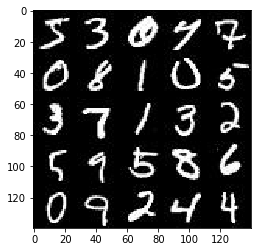

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

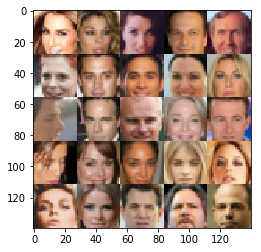

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels])
    input_z = tf.placeholder(tf.float32, shape=[None, z_dim])
    l_rate = tf.placeholder(tf.float32, shape=[])

    return input_real, input_z, l_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.02
    with tf.variable_scope("discriminator", reuse=reuse):
        # Image size 28x28x1 or 28x28x3
        conv = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        conv = tf.layers.batch_normalization(conv)
        conv = tf.maximum(alpha * conv, conv)
        # Image size 14x14x128
        
        conv = tf.layers.conv2d(images, 512, 5, strides=2, padding='same')
        conv = tf.layers.batch_normalization(conv)
        conv = tf.maximum(alpha * conv, conv)
        # Image size 7x7x512
        
        logits = tf.reshape(conv, [-1, 7*7*512])
        logits = tf.layers.dense(logits, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.02
    with tf.variable_scope("generator", reuse=(not is_train)):
        conv_t = tf.layers.dense(z, 7*7*512)
        conv_t = tf.reshape(conv_t, [-1, 7, 7, 512])
        conv_t = tf.layers.batch_normalization(conv_t, training=is_train)
        conv_t = tf.maximum(alpha * conv_t, conv_t)
        # Image size 7x7x512
        
        conv_t = tf.layers.conv2d_transpose(conv_t, 128, 5, strides=2, padding='same')
        conv_t = tf.layers.batch_normalization(conv_t, training=is_train)
        conv_t = tf.maximum(alpha * conv_t, conv_t)
        # Image size 14x14x128
        
        conv_t = tf.layers.conv2d_transpose(conv_t, out_channel_dim, 5, strides=2, padding='same')
        # Image size 28x28xOut_channel_dim
        
        out = tf.tanh(conv_t) # Output
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    all_var = tf.trainable_variables()
    
    dis_var = [d for d in all_var if d.name.startswith('dis')]
    gen_var = [g for g in all_var if g.name.startswith('gen')]
    
    #with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    g_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_var)
    d_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_var)

    return d_op, g_op


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every = 25
    out_channel_dim = len(data_image_mode)
    
    input_real, input_z, learn_r = model_inputs(data_shape[1], data_shape[2], out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_r, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_count, batch_images in enumerate(get_batches(batch_size)):
                batch_i = tf.multiply(batch_images, 2)
                batch_z = np.random.uniform(-0.5, 0.5, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_r:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, learn_r:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, learn_r:learning_rate})
                
                if (batch_count % print_every) == 0: 
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    if (batch_count % (print_every*10)) == 0: 
                        show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
                        
                    print("Epoch {}/{}... Batch {}...".format(epoch_i+1, epoch_count, batch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    
        show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

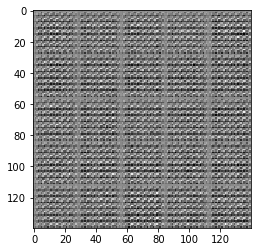

Epoch 1/2... Batch 0... Discriminator Loss: 1.3841... Generator Loss: 0.6368
Epoch 1/2... Batch 25... Discriminator Loss: 1.4448... Generator Loss: 0.7329
Epoch 1/2... Batch 50... Discriminator Loss: 1.3915... Generator Loss: 0.6917
Epoch 1/2... Batch 75... Discriminator Loss: 1.4025... Generator Loss: 0.6705
Epoch 1/2... Batch 100... Discriminator Loss: 1.3914... Generator Loss: 0.6595
Epoch 1/2... Batch 125... Discriminator Loss: 1.3955... Generator Loss: 0.6478
Epoch 1/2... Batch 150... Discriminator Loss: 1.3868... Generator Loss: 0.6907
Epoch 1/2... Batch 175... Discriminator Loss: 1.3936... Generator Loss: 0.6727
Epoch 1/2... Batch 200... Discriminator Loss: 1.3916... Generator Loss: 0.6802
Epoch 1/2... Batch 225... Discriminator Loss: 1.3917... Generator Loss: 0.6855


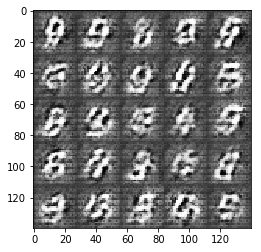

Epoch 1/2... Batch 250... Discriminator Loss: 1.3925... Generator Loss: 0.6974
Epoch 1/2... Batch 275... Discriminator Loss: 1.3750... Generator Loss: 0.6864
Epoch 1/2... Batch 300... Discriminator Loss: 1.3825... Generator Loss: 0.6735
Epoch 1/2... Batch 325... Discriminator Loss: 1.3850... Generator Loss: 0.6893
Epoch 1/2... Batch 350... Discriminator Loss: 1.3778... Generator Loss: 0.7007
Epoch 1/2... Batch 375... Discriminator Loss: 1.3779... Generator Loss: 0.6985
Epoch 1/2... Batch 400... Discriminator Loss: 1.3740... Generator Loss: 0.6888
Epoch 1/2... Batch 425... Discriminator Loss: 1.3674... Generator Loss: 0.6967
Epoch 1/2... Batch 450... Discriminator Loss: 1.3763... Generator Loss: 0.6951
Epoch 1/2... Batch 475... Discriminator Loss: 1.3629... Generator Loss: 0.7642


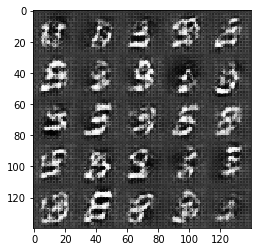

Epoch 1/2... Batch 500... Discriminator Loss: 1.3514... Generator Loss: 0.7262
Epoch 1/2... Batch 525... Discriminator Loss: 1.3614... Generator Loss: 0.7189
Epoch 1/2... Batch 550... Discriminator Loss: 1.3674... Generator Loss: 0.6834
Epoch 1/2... Batch 575... Discriminator Loss: 1.3224... Generator Loss: 0.7438
Epoch 1/2... Batch 600... Discriminator Loss: 1.3491... Generator Loss: 0.6804
Epoch 1/2... Batch 625... Discriminator Loss: 1.3582... Generator Loss: 0.7018
Epoch 1/2... Batch 650... Discriminator Loss: 1.3552... Generator Loss: 0.6703
Epoch 1/2... Batch 675... Discriminator Loss: 1.3457... Generator Loss: 0.6873
Epoch 1/2... Batch 700... Discriminator Loss: 1.3492... Generator Loss: 0.6916
Epoch 1/2... Batch 725... Discriminator Loss: 1.3413... Generator Loss: 0.7207


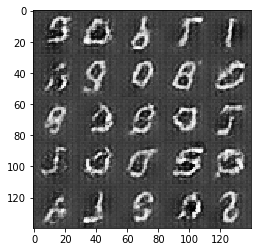

Epoch 1/2... Batch 750... Discriminator Loss: 1.3239... Generator Loss: 0.7213
Epoch 1/2... Batch 775... Discriminator Loss: 1.3308... Generator Loss: 0.6643
Epoch 1/2... Batch 800... Discriminator Loss: 1.3379... Generator Loss: 0.6722
Epoch 1/2... Batch 825... Discriminator Loss: 1.3026... Generator Loss: 0.7119
Epoch 1/2... Batch 850... Discriminator Loss: 1.3327... Generator Loss: 0.6904
Epoch 1/2... Batch 875... Discriminator Loss: 1.3245... Generator Loss: 0.6839
Epoch 1/2... Batch 900... Discriminator Loss: 1.2933... Generator Loss: 0.7289
Epoch 1/2... Batch 925... Discriminator Loss: 1.3216... Generator Loss: 0.7091


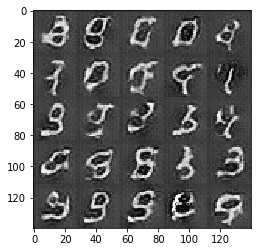

Epoch 2/2... Batch 0... Discriminator Loss: 1.3189... Generator Loss: 0.7127
Epoch 2/2... Batch 25... Discriminator Loss: 1.3095... Generator Loss: 0.7276
Epoch 2/2... Batch 50... Discriminator Loss: 1.3213... Generator Loss: 0.7339
Epoch 2/2... Batch 75... Discriminator Loss: 1.3075... Generator Loss: 0.7053
Epoch 2/2... Batch 100... Discriminator Loss: 1.2982... Generator Loss: 0.7367
Epoch 2/2... Batch 125... Discriminator Loss: 1.2971... Generator Loss: 0.6866
Epoch 2/2... Batch 150... Discriminator Loss: 1.2880... Generator Loss: 0.7525
Epoch 2/2... Batch 175... Discriminator Loss: 1.2474... Generator Loss: 0.6992
Epoch 2/2... Batch 200... Discriminator Loss: 1.3184... Generator Loss: 0.5941
Epoch 2/2... Batch 225... Discriminator Loss: 1.2656... Generator Loss: 0.7508


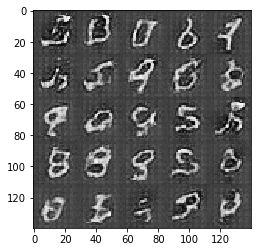

Epoch 2/2... Batch 250... Discriminator Loss: 1.2328... Generator Loss: 0.8143
Epoch 2/2... Batch 275... Discriminator Loss: 1.2604... Generator Loss: 0.7543
Epoch 2/2... Batch 300... Discriminator Loss: 1.2790... Generator Loss: 0.5972
Epoch 2/2... Batch 325... Discriminator Loss: 1.2830... Generator Loss: 0.7031
Epoch 2/2... Batch 350... Discriminator Loss: 1.2711... Generator Loss: 0.6695
Epoch 2/2... Batch 375... Discriminator Loss: 1.2834... Generator Loss: 0.6968
Epoch 2/2... Batch 400... Discriminator Loss: 1.2122... Generator Loss: 0.7401
Epoch 2/2... Batch 425... Discriminator Loss: 1.2633... Generator Loss: 0.7318
Epoch 2/2... Batch 450... Discriminator Loss: 1.2728... Generator Loss: 0.8204
Epoch 2/2... Batch 475... Discriminator Loss: 1.2275... Generator Loss: 0.7423


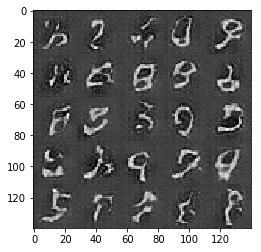

Epoch 2/2... Batch 500... Discriminator Loss: 1.2633... Generator Loss: 0.7128
Epoch 2/2... Batch 525... Discriminator Loss: 1.2467... Generator Loss: 0.7198
Epoch 2/2... Batch 550... Discriminator Loss: 1.2801... Generator Loss: 0.6303
Epoch 2/2... Batch 575... Discriminator Loss: 1.2831... Generator Loss: 0.7549
Epoch 2/2... Batch 600... Discriminator Loss: 1.3162... Generator Loss: 0.5492
Epoch 2/2... Batch 625... Discriminator Loss: 1.2997... Generator Loss: 0.6229
Epoch 2/2... Batch 650... Discriminator Loss: 1.1725... Generator Loss: 0.8669
Epoch 2/2... Batch 675... Discriminator Loss: 1.3133... Generator Loss: 0.5437
Epoch 2/2... Batch 700... Discriminator Loss: 1.2652... Generator Loss: 0.7720
Epoch 2/2... Batch 725... Discriminator Loss: 1.2506... Generator Loss: 0.8644


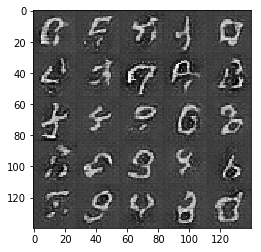

Epoch 2/2... Batch 750... Discriminator Loss: 1.2096... Generator Loss: 0.9654
Epoch 2/2... Batch 775... Discriminator Loss: 1.2858... Generator Loss: 0.5532
Epoch 2/2... Batch 800... Discriminator Loss: 1.2253... Generator Loss: 0.7118
Epoch 2/2... Batch 825... Discriminator Loss: 1.1863... Generator Loss: 0.8032
Epoch 2/2... Batch 850... Discriminator Loss: 1.2689... Generator Loss: 0.6144
Epoch 2/2... Batch 875... Discriminator Loss: 1.2355... Generator Loss: 0.7663
Epoch 2/2... Batch 900... Discriminator Loss: 1.1985... Generator Loss: 0.8503
Epoch 2/2... Batch 925... Discriminator Loss: 1.2072... Generator Loss: 0.8916


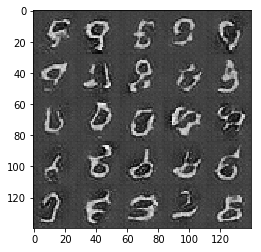

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

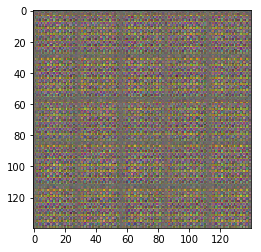

Epoch 1/1... Batch 0... Discriminator Loss: 1.5003... Generator Loss: 0.5737
Epoch 1/1... Batch 25... Discriminator Loss: 1.4141... Generator Loss: 0.6590
Epoch 1/1... Batch 50... Discriminator Loss: 1.3917... Generator Loss: 0.6704
Epoch 1/1... Batch 75... Discriminator Loss: 1.3976... Generator Loss: 0.6623
Epoch 1/1... Batch 100... Discriminator Loss: 1.3587... Generator Loss: 0.7814
Epoch 1/1... Batch 125... Discriminator Loss: 1.3685... Generator Loss: 0.7289
Epoch 1/1... Batch 150... Discriminator Loss: 1.4106... Generator Loss: 0.6773
Epoch 1/1... Batch 175... Discriminator Loss: 1.4221... Generator Loss: 0.6855
Epoch 1/1... Batch 200... Discriminator Loss: 1.4259... Generator Loss: 0.6442
Epoch 1/1... Batch 225... Discriminator Loss: 1.4108... Generator Loss: 0.6817


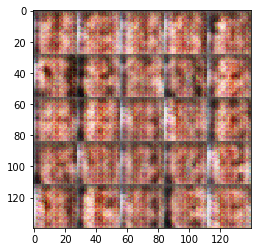

Epoch 1/1... Batch 250... Discriminator Loss: 1.3876... Generator Loss: 0.7347
Epoch 1/1... Batch 275... Discriminator Loss: 1.4042... Generator Loss: 0.6650
Epoch 1/1... Batch 300... Discriminator Loss: 1.3830... Generator Loss: 0.6800
Epoch 1/1... Batch 325... Discriminator Loss: 1.3931... Generator Loss: 0.6766
Epoch 1/1... Batch 350... Discriminator Loss: 1.3722... Generator Loss: 0.6872
Epoch 1/1... Batch 375... Discriminator Loss: 1.4121... Generator Loss: 0.6682
Epoch 1/1... Batch 400... Discriminator Loss: 1.4157... Generator Loss: 0.6951
Epoch 1/1... Batch 425... Discriminator Loss: 1.4141... Generator Loss: 0.6594
Epoch 1/1... Batch 450... Discriminator Loss: 1.4152... Generator Loss: 0.6602
Epoch 1/1... Batch 475... Discriminator Loss: 1.4283... Generator Loss: 0.7124


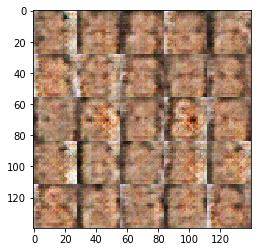

Epoch 1/1... Batch 500... Discriminator Loss: 1.3895... Generator Loss: 0.6807
Epoch 1/1... Batch 525... Discriminator Loss: 1.3928... Generator Loss: 0.7071
Epoch 1/1... Batch 550... Discriminator Loss: 1.3793... Generator Loss: 0.6945
Epoch 1/1... Batch 575... Discriminator Loss: 1.3755... Generator Loss: 0.7155
Epoch 1/1... Batch 600... Discriminator Loss: 1.3845... Generator Loss: 0.6916
Epoch 1/1... Batch 625... Discriminator Loss: 1.3955... Generator Loss: 0.7109
Epoch 1/1... Batch 650... Discriminator Loss: 1.3861... Generator Loss: 0.6894
Epoch 1/1... Batch 675... Discriminator Loss: 1.3885... Generator Loss: 0.7023
Epoch 1/1... Batch 700... Discriminator Loss: 1.3813... Generator Loss: 0.6620
Epoch 1/1... Batch 725... Discriminator Loss: 1.4100... Generator Loss: 0.6695


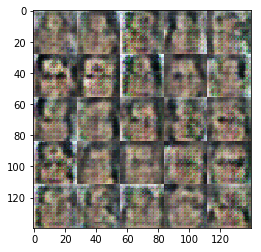

Epoch 1/1... Batch 750... Discriminator Loss: 1.3750... Generator Loss: 0.7233
Epoch 1/1... Batch 775... Discriminator Loss: 1.4063... Generator Loss: 0.6917
Epoch 1/1... Batch 800... Discriminator Loss: 1.3825... Generator Loss: 0.6974
Epoch 1/1... Batch 825... Discriminator Loss: 1.3773... Generator Loss: 0.7134
Epoch 1/1... Batch 850... Discriminator Loss: 1.3923... Generator Loss: 0.6643
Epoch 1/1... Batch 875... Discriminator Loss: 1.3832... Generator Loss: 0.7036
Epoch 1/1... Batch 900... Discriminator Loss: 1.4265... Generator Loss: 0.6762
Epoch 1/1... Batch 925... Discriminator Loss: 1.4038... Generator Loss: 0.6817
Epoch 1/1... Batch 950... Discriminator Loss: 1.3781... Generator Loss: 0.6846
Epoch 1/1... Batch 975... Discriminator Loss: 1.3848... Generator Loss: 0.6985


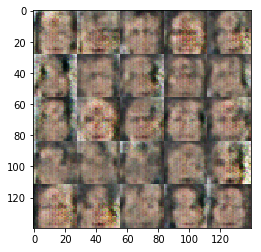

Epoch 1/1... Batch 1000... Discriminator Loss: 1.3763... Generator Loss: 0.7034
Epoch 1/1... Batch 1025... Discriminator Loss: 1.3954... Generator Loss: 0.6995
Epoch 1/1... Batch 1050... Discriminator Loss: 1.3778... Generator Loss: 0.6942
Epoch 1/1... Batch 1075... Discriminator Loss: 1.4070... Generator Loss: 0.7140
Epoch 1/1... Batch 1100... Discriminator Loss: 1.3959... Generator Loss: 0.7020
Epoch 1/1... Batch 1125... Discriminator Loss: 1.3803... Generator Loss: 0.7175
Epoch 1/1... Batch 1150... Discriminator Loss: 1.3790... Generator Loss: 0.7485
Epoch 1/1... Batch 1175... Discriminator Loss: 1.3829... Generator Loss: 0.7103
Epoch 1/1... Batch 1200... Discriminator Loss: 1.3757... Generator Loss: 0.7673
Epoch 1/1... Batch 1225... Discriminator Loss: 1.3940... Generator Loss: 0.7468


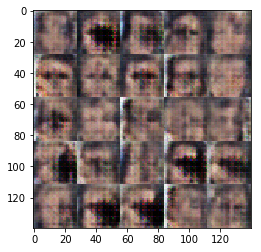

Epoch 1/1... Batch 1250... Discriminator Loss: 1.4399... Generator Loss: 0.5933
Epoch 1/1... Batch 1275... Discriminator Loss: 1.3889... Generator Loss: 0.6862
Epoch 1/1... Batch 1300... Discriminator Loss: 1.3811... Generator Loss: 0.6757
Epoch 1/1... Batch 1325... Discriminator Loss: 1.4975... Generator Loss: 0.5888
Epoch 1/1... Batch 1350... Discriminator Loss: 1.4104... Generator Loss: 0.6995
Epoch 1/1... Batch 1375... Discriminator Loss: 1.3861... Generator Loss: 0.6988
Epoch 1/1... Batch 1400... Discriminator Loss: 1.4049... Generator Loss: 0.6905
Epoch 1/1... Batch 1425... Discriminator Loss: 1.3675... Generator Loss: 0.6781
Epoch 1/1... Batch 1450... Discriminator Loss: 1.3836... Generator Loss: 0.6879
Epoch 1/1... Batch 1475... Discriminator Loss: 1.3912... Generator Loss: 0.7031


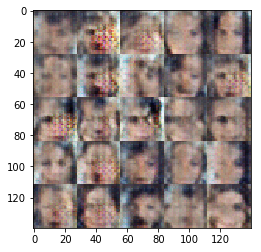

Epoch 1/1... Batch 1500... Discriminator Loss: 1.3925... Generator Loss: 0.7056
Epoch 1/1... Batch 1525... Discriminator Loss: 1.4055... Generator Loss: 0.6510
Epoch 1/1... Batch 1550... Discriminator Loss: 1.3775... Generator Loss: 0.6932
Epoch 1/1... Batch 1575... Discriminator Loss: 1.4036... Generator Loss: 0.6891
Epoch 1/1... Batch 1600... Discriminator Loss: 1.3894... Generator Loss: 0.6892
Epoch 1/1... Batch 1625... Discriminator Loss: 1.3887... Generator Loss: 0.6985
Epoch 1/1... Batch 1650... Discriminator Loss: 1.3987... Generator Loss: 0.6930
Epoch 1/1... Batch 1675... Discriminator Loss: 1.3858... Generator Loss: 0.6884
Epoch 1/1... Batch 1700... Discriminator Loss: 1.3864... Generator Loss: 0.6943
Epoch 1/1... Batch 1725... Discriminator Loss: 1.3929... Generator Loss: 0.6997


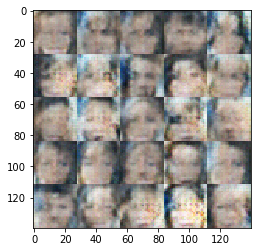

Epoch 1/1... Batch 1750... Discriminator Loss: 1.3887... Generator Loss: 0.6845
Epoch 1/1... Batch 1775... Discriminator Loss: 1.3849... Generator Loss: 0.6980
Epoch 1/1... Batch 1800... Discriminator Loss: 1.3853... Generator Loss: 0.6948
Epoch 1/1... Batch 1825... Discriminator Loss: 1.3932... Generator Loss: 0.6977
Epoch 1/1... Batch 1850... Discriminator Loss: 1.3858... Generator Loss: 0.6954
Epoch 1/1... Batch 1875... Discriminator Loss: 1.3859... Generator Loss: 0.7075
Epoch 1/1... Batch 1900... Discriminator Loss: 1.3960... Generator Loss: 0.6739
Epoch 1/1... Batch 1925... Discriminator Loss: 1.3974... Generator Loss: 0.6888
Epoch 1/1... Batch 1950... Discriminator Loss: 1.3893... Generator Loss: 0.6949
Epoch 1/1... Batch 1975... Discriminator Loss: 1.3839... Generator Loss: 0.6937


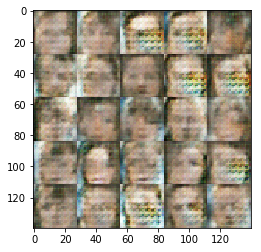

Epoch 1/1... Batch 2000... Discriminator Loss: 1.3901... Generator Loss: 0.6853
Epoch 1/1... Batch 2025... Discriminator Loss: 1.4311... Generator Loss: 0.6191
Epoch 1/1... Batch 2050... Discriminator Loss: 1.3842... Generator Loss: 0.7171
Epoch 1/1... Batch 2075... Discriminator Loss: 1.3872... Generator Loss: 0.6887
Epoch 1/1... Batch 2100... Discriminator Loss: 1.3894... Generator Loss: 0.6809
Epoch 1/1... Batch 2125... Discriminator Loss: 1.3924... Generator Loss: 0.7041
Epoch 1/1... Batch 2150... Discriminator Loss: 1.3876... Generator Loss: 0.7007
Epoch 1/1... Batch 2175... Discriminator Loss: 1.3837... Generator Loss: 0.7025
Epoch 1/1... Batch 2200... Discriminator Loss: 1.3918... Generator Loss: 0.6893
Epoch 1/1... Batch 2225... Discriminator Loss: 1.3885... Generator Loss: 0.7000


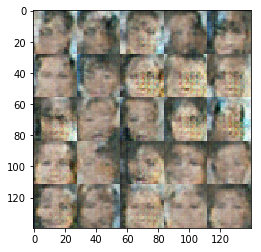

Epoch 1/1... Batch 2250... Discriminator Loss: 1.3912... Generator Loss: 0.6983
Epoch 1/1... Batch 2275... Discriminator Loss: 1.3844... Generator Loss: 0.6963
Epoch 1/1... Batch 2300... Discriminator Loss: 1.3856... Generator Loss: 0.7031
Epoch 1/1... Batch 2325... Discriminator Loss: 1.3969... Generator Loss: 0.6468
Epoch 1/1... Batch 2350... Discriminator Loss: 1.3835... Generator Loss: 0.6883
Epoch 1/1... Batch 2375... Discriminator Loss: 1.3922... Generator Loss: 0.7201
Epoch 1/1... Batch 2400... Discriminator Loss: 1.3702... Generator Loss: 0.6901
Epoch 1/1... Batch 2425... Discriminator Loss: 1.3883... Generator Loss: 0.7030
Epoch 1/1... Batch 2450... Discriminator Loss: 1.4363... Generator Loss: 0.7131
Epoch 1/1... Batch 2475... Discriminator Loss: 1.3527... Generator Loss: 0.7688


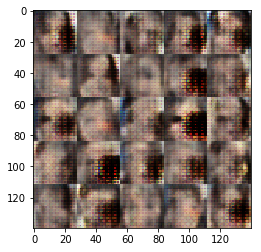

Epoch 1/1... Batch 2500... Discriminator Loss: 1.3723... Generator Loss: 0.7524
Epoch 1/1... Batch 2525... Discriminator Loss: 1.4170... Generator Loss: 0.6527
Epoch 1/1... Batch 2550... Discriminator Loss: 1.3892... Generator Loss: 0.7624
Epoch 1/1... Batch 2575... Discriminator Loss: 1.3767... Generator Loss: 0.7028
Epoch 1/1... Batch 2600... Discriminator Loss: 1.3937... Generator Loss: 0.7352
Epoch 1/1... Batch 2625... Discriminator Loss: 1.4032... Generator Loss: 0.6902
Epoch 1/1... Batch 2650... Discriminator Loss: 1.3890... Generator Loss: 0.7083
Epoch 1/1... Batch 2675... Discriminator Loss: 1.3872... Generator Loss: 0.6841
Epoch 1/1... Batch 2700... Discriminator Loss: 1.3799... Generator Loss: 0.7035
Epoch 1/1... Batch 2725... Discriminator Loss: 1.4073... Generator Loss: 0.7170


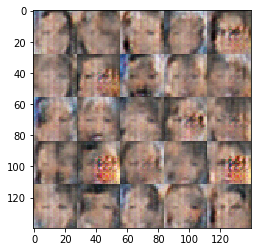

Epoch 1/1... Batch 2750... Discriminator Loss: 1.3851... Generator Loss: 0.6918
Epoch 1/1... Batch 2775... Discriminator Loss: 1.3842... Generator Loss: 0.7104
Epoch 1/1... Batch 2800... Discriminator Loss: 1.3894... Generator Loss: 0.6905
Epoch 1/1... Batch 2825... Discriminator Loss: 1.3872... Generator Loss: 0.6987
Epoch 1/1... Batch 2850... Discriminator Loss: 1.3859... Generator Loss: 0.6928
Epoch 1/1... Batch 2875... Discriminator Loss: 1.3860... Generator Loss: 0.7181
Epoch 1/1... Batch 2900... Discriminator Loss: 1.3848... Generator Loss: 0.6894
Epoch 1/1... Batch 2925... Discriminator Loss: 1.3863... Generator Loss: 0.6845
Epoch 1/1... Batch 2950... Discriminator Loss: 1.3877... Generator Loss: 0.6979
Epoch 1/1... Batch 2975... Discriminator Loss: 1.3857... Generator Loss: 0.6926


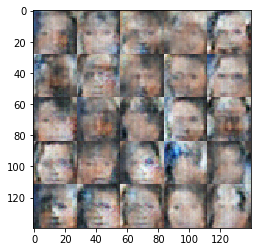

Epoch 1/1... Batch 3000... Discriminator Loss: 1.3900... Generator Loss: 0.6965
Epoch 1/1... Batch 3025... Discriminator Loss: 1.3862... Generator Loss: 0.6936
Epoch 1/1... Batch 3050... Discriminator Loss: 1.3871... Generator Loss: 0.6919
Epoch 1/1... Batch 3075... Discriminator Loss: 1.3861... Generator Loss: 0.6945
Epoch 1/1... Batch 3100... Discriminator Loss: 1.3854... Generator Loss: 0.7044
Epoch 1/1... Batch 3125... Discriminator Loss: 1.3902... Generator Loss: 0.6818
Epoch 1/1... Batch 3150... Discriminator Loss: 1.3984... Generator Loss: 0.7179


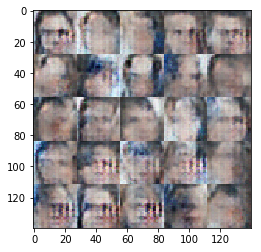

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.